In [19]:
from __future__ import print_function

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adadelta, Adagrad, Adam, Nadam, SGD
from keras.callbacks import EarlyStopping, TerminateOnNaN
from keras import backend as K
from keras.losses import mean_squared_error
from keras.models import load_model, Model
import tensorflow as tf

# Normalize the data.
from sklearn import preprocessing
from keras.regularizers import l1_l2

import random


def pass_arg(Xx, nsim, tr_size):
    print("Tr_size:", tr_size)
    def fix_seeds(seed):
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
        session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    #     K.set_session(sess)
        tf.compat.v1.keras.backend.set_session(sess)

    ss = 1
    fix_seeds(ss)

    # Compute the RMSE given the ground truth (y_true) and the predictions(y_pred)
    def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))


    def PGNN_train_test(optimizer_name, optimizer_val, drop_rate, iteration, n_layers, n_nodes, tr_size, pre_train):

        # Hyper-parameters of the training process
    #     batch_size = int(tr_size/2)
        batch_size = 1
        num_epochs = 300
        val_frac = 0.25
        patience_val = 80

        # Initializing results filename
        exp_name = "Pre-train" + optimizer_name + '_drop' + str(drop_rate) + '_nL' + str(n_layers) + '_nN' + str(n_nodes) + '_trsize' + str(tr_size) + '_iter' + str(iteration)
        exp_name = exp_name.replace('.','pt')
        results_dir = '../results/'
        model_name = results_dir + exp_name + '.h5' # storing the trained model
        results_name = results_dir + exp_name + '_results.dat' # storing the results of the model
        
        # Load labeled data
        # data = np.loadtxt('../data/unlabeled_data_BK_constw_v2_1525.dat')
        
        # data1 = data[:1303, :]
        # data2 = data[-6:, :]
        # datah = np.vstack((data1,data2))
        # np.random.shuffle(datah)
        # x_unlabeled = datah[:, :2] # 1303 last regular sample
        # y_unlabeled = datah[:, -3:-1]

        # Load labeled data
        data = np.loadtxt('../data/labeled_data.dat')
        x_labeled = data[:, :2] # -2 because we do not need porosity predictions
        y_labeled = data[:, -2:-1] # dimensionless bond length and

        # normalize dataset with MinMaxScaler
        scaler = preprocessing.MinMaxScaler(feature_range=(0, 1.0))
    #     scaler = preprocessing.StandardScaler()
        x_labeled = scaler.fit_transform(x_labeled)
        # x_unlabeled = scaler.fit_transform(x_unlabeled)
        # y_labeled = scaler.fit_transform(y_labeled)

        # train and test data
        trainX, trainY = x_labeled[:tr_size,:], y_labeled[:tr_size]
        testX, testY = x_labeled[tr_size:,:], y_labeled[tr_size:]

        dependencies = {'root_mean_squared_error': root_mean_squared_error}
		
        # load the pre-trained model using non-calibrated physics-based model predictions (./data/unlabeled.dat)
        loaded_model = load_model(results_dir + pre_train, custom_objects=dependencies)
		
        # Creating the model
        model = Sequential()
        for layer in np.arange(n_layers):
            if layer == 0:
                model.add(Dense(n_nodes, activation='relu', input_shape=(np.shape(trainX)[1],)))
            else:
                model.add(Dense(n_nodes, activation='relu', kernel_regularizer=l1_l2(l1=.00, l2=.00)))
            model.add(Dropout(rate=drop_rate))
        model.add(Dense(1, activation='linear'))

        # pass the weights to all layers but 1st input layer, whose dimensions are updated
        for new_layer, layer in zip(model.layers[1:], loaded_model.layers[1:]):
            new_layer.set_weights(layer.get_weights())

        model.compile(loss='mean_squared_error',
                      optimizer=optimizer_val,
                      metrics=[root_mean_squared_error])

        early_stopping = EarlyStopping(monitor='val_loss', patience=patience_val,verbose=1)

        print('Running...' + optimizer_name)
        history = model.fit(trainX, trainY,
                            batch_size=batch_size,
                            epochs=num_epochs,
                            verbose=0,
                            validation_split=val_frac, callbacks=[early_stopping, TerminateOnNaN()])

        test_score = model.evaluate(testX, testY, verbose=1)
        print(test_score)

        samples = []
        for i in range(int(nsim)):
            print("simulation num:",i)
            predictions = model.predict(Xx)
            samples.append(predictions[:,np.newaxis])
        return np.array(samples)



    # Main Function
    if __name__ == '__main__':

        fix_seeds(1)

        # List of optimizers to choose from    
        optimizer_names = ['Adagrad', 'Adadelta', 'Adam', 'Nadam', 'RMSprop', 'SGD', 'NSGD']
        optimizer_vals = [Adagrad(clipnorm=1), Adadelta(clipnorm=1), Adam(clipnorm=1), Nadam(clipnorm=1), RMSprop(clipnorm=1), SGD(clipnorm=1.), SGD(clipnorm=1, nesterov=True)]

        # selecting the optimizer
        optimizer_num = 1
        optimizer_name = optimizer_names[optimizer_num]
        optimizer_val = optimizer_vals[optimizer_num]

        # Selecting Other Hyper-parameters
        drop_rate = 0.01 # Fraction of nodes to be dropped out
        n_layers = 2 # Number of hidden layers
        n_nodes = 5 # Number of nodes per hidden layer

        # # Iterating over different training fractions and splitting indices for train-test splits
        # trsize_range = [4,6,8,10,20]

        # #default training size = 5000
        # tr_size = trsize_range[4]
        
        # pre-trained model
        pre_train = 'Poro_Pre-trainAdadelta_drop0_nL2_nN5_trsize1308_iter0.h5'
        tr_size = int(tr_size)

#         # use regularizer
#         reg = True

#         #set lamda=0 for pgnn0
#         lamda = [1, 1] # Physics-based regularization constant

        # total number of runs
        iter_range = np.arange(1)
        testrmse=[]
        # iterating through all possible params
        for iteration in iter_range:
            # results, result_file, pred, obs, rmse = PGNN_train_test(optimizer_name, optimizer_val, drop_rate, 
                            # iteration, n_layers, n_nodes, tr_size, lamda, reg)
            # testrmse.append(rmse)
            pred = PGNN_train_test(optimizer_name, optimizer_val, drop_rate, 
                        iteration, n_layers, n_nodes, tr_size, pre_train)
    print(np.squeeze(pred))
    return np.squeeze(pred)


In [20]:
Xx = np.random.uniform(size=(100, 2))
nsim=1
tr_size=20
pass_arg(Xx,nsim,tr_size)

Tr_size: 20
Running...Adadelta
Epoch 00134: early stopping
19/19 [==============================] - 0s 0us/step
[3.0142211471684277e-05, 0.0043724761344492435]
simulation num: 0
[0.04351421 0.05575085 0.05164307 0.00965366 0.04740286 0.00992528
 0.01015486 0.00684388 0.00782099 0.04843568 0.03507343 0.00288614
 0.05350348 0.00615209 0.00998426 0.02021046 0.05263975 0.00472901
 0.02852927 0.01849188 0.04965083 0.00675169 0.00323234 0.00896744
 0.0470822  0.04188497 0.05409294 0.02613108 0.0431846  0.01031461
 0.00639343 0.02327354 0.00788513 0.03424989 0.05687834 0.03742653
 0.00764    0.02537487 0.04339799 0.00395348 0.00817409 0.03150375
 0.05737574 0.05128383 0.04292828 0.0374822  0.03428449 0.03029831
 0.0444319  0.02797597 0.00376154 0.02119142 0.00849421 0.03823437
 0.029982   0.02861333 0.00693979 0.03776674 0.05307933 0.05552345
 0.04628198 0.03387131 0.01166139 0.01015953 0.02538575 0.00837244
 0.00963096 0.00707568 0.00322903 0.02707468 0.00796915 0.02905833
 0.05034763 0.0089

array([0.04351421, 0.05575085, 0.05164307, 0.00965366, 0.04740286,
       0.00992528, 0.01015486, 0.00684388, 0.00782099, 0.04843568,
       0.03507343, 0.00288614, 0.05350348, 0.00615209, 0.00998426,
       0.02021046, 0.05263975, 0.00472901, 0.02852927, 0.01849188,
       0.04965083, 0.00675169, 0.00323234, 0.00896744, 0.0470822 ,
       0.04188497, 0.05409294, 0.02613108, 0.0431846 , 0.01031461,
       0.00639343, 0.02327354, 0.00788513, 0.03424989, 0.05687834,
       0.03742653, 0.00764   , 0.02537487, 0.04339799, 0.00395348,
       0.00817409, 0.03150375, 0.05737574, 0.05128383, 0.04292828,
       0.0374822 , 0.03428449, 0.03029831, 0.0444319 , 0.02797597,
       0.00376154, 0.02119142, 0.00849421, 0.03823437, 0.029982  ,
       0.02861333, 0.00693979, 0.03776674, 0.05307933, 0.05552345,
       0.04628198, 0.03387131, 0.01166139, 0.01015953, 0.02538575,
       0.00837244, 0.00963096, 0.00707568, 0.00322903, 0.02707468,
       0.00796915, 0.02905833, 0.05034763, 0.00892686, 0.05446

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# Normalize the data.
from sklearn import preprocessing

from sklearn.model_selection import KFold

Define parameters for the model

In [2]:
# Parameters
wght_decay, p_drop, learn_rate = 0.0005, 0.05, 5e-7
train_data_ratio, nb_units, nb_epochs = 0.8, 10, 1000

Define functions to normalize and de-normalize the data

In [3]:
def measurements_and_training_data(num_parts, ratio_):
    # =================================================================================================================== %
    # _______________________________________________       INPUTS     ___________________________________________________
    # =================================================================================================================== %
    wth = 0.8e-3  # width of filaments [m]

    # Reference temperature at which the neck growth is predicted
    ref_temp = 130  # in celcius
    kelv = 273.15  # 0 Celcius in K

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ %

    # =================================================================================================================== %
    # ___________________________________        IMPORT Measured BOND LENGTH DATA     ____________________________________
    # =================================================================================================================== %
    # Directory where measurements are stored
    dir_measurements = "C:/Users/berkc/git/Physics-Informed-Machine-Learning/data/supervised/experiments/"
    dir_temp_data = "C:/Users/berkc/git/Physics-Informed-Machine-Learning/data/supervised/temperature/"

    # IMPORT Measured BOND LENGTH DATA
    start_part_id = 1  # starting ID part
    total_parts = np.arange(start_part_id, num_parts + 1, dtype='int32')

    ctr = 0  # counter of parts
    # num_total_int = 0                              # counter of interfaces
    int_temperature = []  # list stores interface temperature data of all parts' filaments
    measured_bl_row = []  # list stores bond length (BL) data of all parts
    inp = []
    
    # part_info = np.zeros(total_parts.shape[0], dtype='int')
    part_specs = []
    heights = []
    
    hth = 0.7  # same layer height[mm] for all parts
    L = 35 # length of each part in mm
    
    for part_id in total_parts:  # loop over each manufactured part ID

        # Read Process parameters & bond length measurements
        bl_file = dir_measurements + "/Part" + str(part_id) + ".xlsx"

        df = pd.read_excel(bl_file, header=None, sheet_name = 'B')  # read the excel file

        num_layers = df.iloc[2, 0]  # # of layers
        num_interfaces = df.iloc[-2, 1]  # # of interfaces/layer
        num_filaments = num_interfaces + 1  # # of filaments/layer

        # num_layers = int(num_layers)
        # num_interfaces = int(num_interfaces)

        num_interfaces_of_a_part = int(num_layers * num_interfaces)  # num. of interfaces of that part
#         num_filaments_of_a_part = int(num_layers * num_filaments)  # num. of filaments of that part

        # # # of total interface in all parts
        # num_total_int = num_total_int + num_interfaces_of_a_part

        # save printer temperature, speed, height input for each part
        t_n = df.iloc[0, 1]  # Printer nozzle temperature(ºC)
        v_p = df.iloc[0, 3]  # printer speed mm / s
#         hth = df.iloc[0, 5]  # layer height[mm]
        
        t_n = float(t_n)
        v_p = float(v_p)

        # convert data types to float32 for theano
        # hth = hth.astype('float32')

#         print('T_N, v_p, height:', t_n, v_p, hth, "\n")

        raw_measuredbl = df.iloc[2:-1, 3]  # measured bond lengths between each interface
        raw_measuredbl = raw_measuredbl.astype('float32')

        # reshape the measured bond length array & convert to numpy ndarray
        reshaped_measured_bl = raw_measuredbl.values.reshape(num_interfaces, num_layers, order='F').copy()

        # first column is 1st layer and soon(each row is each interface bond length, BL)
        measured_bl = np.fliplr(reshaped_measured_bl)  # flip matrix left to right

        # store measured BL data of all parts in order reshaped in row
        measured_bl_row.append([measured_bl.reshape(num_interfaces_of_a_part).copy()])

        # == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == = %
        # Costa's Analytical Temperature Solution
        # Temperature matrix is saved as csv in "FFE_processDesignVersion_Depo_Seq_SameStartingPointForAllLayers"
        
        # Read Temperature data
        file_name = dir_temp_data + "Part_" + str(part_id)

        # extract time array once outside the loop
        filename = file_name + ".csv"
        
        # extract temperature data for 'part_id' part
        data = pd.read_csv(filename, header=None, index_col=None)
        t_c = data.apply(pd.to_numeric, errors='coerce')

        # Kelvin conversion
        kelv = 273.150

        # Convert built Python list of strings to a Numpy float array.
        t_c = np.array(t_c)
        
        # convert Celcius to Kelvin
        temp = t_c + kelv
        
       # == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == = %
        
        # Average two adjacent lines' temperatures to obtain interface temperatures for each interface on that layer
        # initialize matrix for Interface Temperatures
        int_temp = np.zeros((temp.shape[0], num_interfaces_of_a_part), dtype='float32')

        # Interpolate interface temperatures
        kk_int = 0  # count  # of interfaces
        for jj in range(1, num_layers + 1):  # loop over layers
            for ii in range(2, num_filaments + 1):  # loop over filaments on jj - th layer

                kk_fil = (jj - 1) * (num_filaments - 1) + ii + jj - 2  # filament ID
                
                # find the index value when (kk + 1)th filament is started to extruded
                t_idx = np.argmax(temp[:, kk_fil] < (t_n + kelv))  # Since argmaxx will stop at the first True

                # find the first index that temp value is lower than Ref_temp
                t_idx_ = np.argmax((temp[:, kk_fil] + temp[:, kk_fil - 1]) / 2 < ref_temp + kelv) + 1

                # average two filament's temp. to obtain interface temp.
                int_temp[0:t_idx_ - t_idx, kk_int] = (temp[t_idx:t_idx_, kk_fil - 1] + temp[t_idx:t_idx_, kk_fil]) / 2
                kk_int += 1
        
        # store each parts' interface temperature in cell array
        int_temperature.append(int_temp)

        
        
        # Prediction inputs are x & y coordinates of vertical bond length locations
        # x, y coordinate of layer 1 & interface 1(vertical)
        # x = wth;
        ycoord = 0.5 * hth  # 0.5*height of a layer in mm
        iki_y = ycoord * 2

        # store inputs for GP(model disrepancy at each interface)
        for jj in range(1, num_layers + 1):
            for ii in range(1, num_interfaces + 1):
                # use x & y coordinates of vertical bonds as training data for the GP
                # Inp =[ Temperature, speed, height, x, y ]
#                 inp.append([t_n, v_p, hth, ii * 1e3*wth, ycoord + (jj - 1) * iki_y])
                inp.append([t_n, v_p, ii * 1e3*wth, ycoord + (jj - 1) * iki_y])

        
        part_specs.append([t_n, v_p, hth, 1e3*wth, num_layers, num_interfaces, L])
        heights.append(hth)
        
        ctr += 1  # increment counter to keep track of total number of parts analyzed

    # Inp: stored inputs for Gaussian process
    # (model disrepancy at each interface):
    #           [T_N, v_p, hth, x, y]
    # Convert built Python lists to a Numpy array.
    inp = np.array(inp, dtype='float64')
    
    # Convert built Python lists to a Numpy array.
    int_temperature = np.array(int_temperature)

    # concatenating different size arrays stored in a list
    measured_bl_row = np.concatenate(measured_bl_row, axis=1)
    measured_bl_row = measured_bl_row.T  # transpose s.t. the number of rows matches Inp

    # stack X and y
    alldata = np.hstack((inp, measured_bl_row))  # stack 2 numpy arrays column-wise

    # -------------------------------------------------------------------------
    #               Random Permutation of Training Data
    # -------------------------------------------------------------------------
    nl = inp.shape[0]  # size of training data

    # randomly select RatioToBeUsed to be training set for GP model
    num_train = round(ratio_ * nl)
#     idx_ = np.random.permutation(nl)
    idx_ = np.arange(nl)  # do not do random permutation

    # Use the first RatioToBeUsed to train the model
    idx_train = idx_[0:num_train]
    
    # train data = [X, Y]
    all_data_train = alldata[idx_train, :]

    # The (1-RatioToBeUsed) will be used to test the model
    idx_test = idx_[(num_train + 1):]
    all_data_test = alldata[idx_test, :]

    x = all_data_train[:, :-1]  # training data, for all but last column
    y = all_data_train[:, -1]  # measurements of the training data, last column
    
#     return x, y, ctr, int_temperature, idx_train, heights, part_specs
    return alldata

Load the data by calling the function we defined above:

In [4]:
# id of the final part that wants to be included in the analysis, 
num_parts_last = 39

# Percent of the whole data is used to train the model
ratio = 1

# load training and test data
# train_data, x_tst, y_tst, BL_sets = measurements_and_training_data()
train_data = measurements_and_training_data(num_parts_last, ratio)

x = train_data[:, :-1]  # training data, for all but last column
y = train_data[:, -1]  # measurements of the training data, last column

# Replace the values of  bond length (BL) that are less than 0.1 with 0.
# The reason for this is that the BL values were supposed to be zero,
# for those interfaces but not recorded so.
y[y<0.1] = 0

# save max and min values of x and y
max_x = x.max(axis=0)
min_x = x.min(axis=0)
max_y = y.max(axis=0)
min_y = y.min(axis=0)

# x = normalize_max_min(x, max_x, min_x)
# y = normalize_max_min(y, max_y, min_y)

# stack input and output data
train_data = np.column_stack((x,y))

# normalize dataset with MinMaxScaler
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1.0))
data = scaler.fit_transform(train_data)

batch_size = train_data.shape[0]

Define functions and classes for the BNN:

In [71]:
def to_variable(var=(), cuda=False, volatile=False):
    out = []
    for v in var:

        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        # if not v.is_cuda and cuda:
        #     v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

def log_gaussian_loss(output, target, sigma, no_dim):
    exponent = -0.5 * (target - output) ** 2 / sigma ** 2
    log_coeff = -no_dim * torch.log(sigma) - 0.5 * no_dim * np.log(2 * np.pi)
    return - (log_coeff + exponent).sum()



class MC_Dropout_Model(nn.Module):
    def __init__(self, input_dim, output_dim, num_units, drop_prob):
        super(MC_Dropout_Model, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.drop_prob = drop_prob

        # network with two hidden and one output layer
        self.layer1 = nn.Linear(input_dim, num_units)
        self.layer2 = nn.Linear(num_units, num_units)
        # self.layer3 = nn.Linear(num_units, num_units)
        # self.layer4 = nn.Linear(num_units, num_units)
        self.layer3 = nn.Linear(num_units, 2 * output_dim)

        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = x.view(-1, self.input_dim)

        x = self.layer1(x)
        x = self.activation(x)
        x = F.dropout(x, p=self.drop_prob, training=True)

        x = self.layer2(x)
        x = self.activation(x)
        x = F.dropout(x, p=self.drop_prob, training=True)
        #
        # x = self.layer3(x)
        # x = self.activation(x)
        # x = F.dropout(x, p=self.drop_prob, training=True)
        #
        # x = self.layer4(x)
        # x = self.activation(x)
        # x = F.dropout(x, p=self.drop_prob, training=True)

        x = self.layer3(x)

        return x


class MC_Dropout_Wrapper:
    def __init__(self, network, learn_rate, batch_size, weight_decay):
        self.learn_rate = learn_rate
        self.batch_size = batch_size

        self.network = network
        # self.network.cuda()

#         self.optimizer = torch.optim.SGD(self.network.parameters(), lr=learn_rate, weight_decay=weight_decay)
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=learn_rate, weight_decay=weight_decay)
        self.loss_func = log_gaussian_loss

    def fit(self, x, y):
        x, y = to_variable(var=(x, y), cuda=True)

        # reset gradient and total loss
        self.optimizer.zero_grad()

        output = self.network(x)

        loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)

        loss.backward()
        self.optimizer.step()

        return loss

    def get_loss_and_rmse(self, x, y, num_samples):
        x, y = to_variable(var=(x, y), cuda=True)

        means, stds = [], []
        for i in range(num_samples):
            output = self.network(x)
            means.append(output[:, :1])
            stds.append(output[:, 1:].exp())

        means, stds = torch.cat(means, dim=1), torch.cat(stds, dim=1)
        mean = means.mean(dim=-1)[:, None]
        std = ((means.var(dim=-1) + stds.mean(dim=-1) ** 2) ** 0.5)[:, None]
        loss = self.loss_func(mean, y, std, 1)

        rmse = ((mean - y) ** 2).mean() ** 0.5

        return loss.detach().cpu(), rmse.detach().cpu()


Define the function that fits the BNN and shuffles the data and use some for testing.

In [72]:
def train_mc_dropout(data, drop_prob, ratio_train_data, num_epochs, num_units, learn_rate, weight_decay, log_every,
                     num_samples):

    in_dim = data.shape[1] - 1
    train_logliks, test_logliks = [], []
    train_rmses, test_rmses = [], []

    history_loss, history_loss_test, history_rmse, history_rmse_test = [], [], [], []

    # -------------------------------------------------------------------------
    #               Random Permutation of Training Data
    # -------------------------------------------------------------------------
    nl = data.shape[0]  # size of training data

    # randomly select RatioToBeUsed to be training set for GP model
    num_train = round(ratio_train_data * nl)
    idx_ = np.random.permutation(nl)
    # idx_ = np.arange(nl)  # do not do random permutation

    # Use the first RatioToBeUsed to train the model
    idx_train = idx_[0:num_train]

    x_train, y_train = data[idx_train, :in_dim], data[idx_train, in_dim:]

    # The (1-RatioToBeUsed) will be used to test the model
    idx_test = idx_[(num_train + 1):]
    x_test, y_test = data[idx_test, :in_dim], data[idx_test, in_dim:]

    y_means, y_stds = y_train.mean(axis=0), y_train.var(axis=0) ** 0.5

    net = MC_Dropout_Wrapper(
            network=MC_Dropout_Model(input_dim=in_dim, output_dim=1, num_units=num_units, drop_prob=drop_prob),
            learn_rate=learn_rate, batch_size=batch_size, weight_decay=weight_decay)

    for i in range(num_epochs):

        loss = net.fit(x_train, y_train)

        tt, rmse_train = net.get_loss_and_rmse(x_train, y_train, num_samples=num_samples)
        rmse_train = rmse_train.cpu().data.numpy()

        test_loss, rmse_test = net.get_loss_and_rmse(x_test, y_test, num_samples=num_samples)
        test_loss, rmse_test = test_loss.cpu().data.numpy(), rmse_test.cpu().data.numpy()

        history_loss.append(loss.cpu().data.numpy() / len(x_train))
        history_loss_test.append(test_loss / len(x_test))
        history_rmse.append(rmse_train )
        history_rmse_test.append(rmse_test )

        if i % log_every == 0 or i == num_epochs - 1:
            test_loss, rmse = net.get_loss_and_rmse(x_test, y_test, num_samples=num_samples)
            test_loss, rmse = test_loss.cpu().data.numpy(), rmse.cpu().data.numpy()

            print('Epoch: %4d, Train loss: %6.3f Test loss: %6.3f RMSE: %.3f' %
                    (i, loss.cpu().data.numpy() / len(x_train), test_loss / len(x_test), rmse ))

    train_loss, train_rmse = net.get_loss_and_rmse(x_train, y_train, num_samples=num_samples)
    test_loss, test_rmse = net.get_loss_and_rmse(x_test, y_test, num_samples=num_samples)

    train_logliks.append((train_loss.cpu().data.numpy() / len(x_train) + np.log(y_stds)[0]))
    test_logliks.append((test_loss.cpu().data.numpy() / len(x_test) + np.log(y_stds)[0]))

    train_rmses.append(train_rmse.cpu().data.numpy())
    test_rmses.append(test_rmse.cpu().data.numpy())

    plt.figure()
    # plot history of accuracy
    # Plot training & validation accuracy values
    plt.plot(history_rmse)
    plt.plot(history_rmse_test)
    plt.title('Model accuracy')
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.figure()
    # Plot training & validation loss values
    plt.plot(history_loss)
    plt.plot(history_loss_test)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    print('Train log. lik. = %6.3f +/- %6.3f' % (-np.array(train_logliks).mean(), np.array(train_logliks).var() ** 0.5))
    print('Test  log. lik. = %6.3f +/- %6.3f' % (-np.array(test_logliks).mean(), np.array(test_logliks).var() ** 0.5))
    print('Train RMSE      = %6.3f +/- %6.3f' % (np.array(train_rmses).mean(), np.array(train_rmses).var() ** 0.5))
    print('Test  RMSE      = %6.3f +/- %6.3f' % (np.array(test_rmses).mean(), np.array(test_rmses).var() ** 0.5))

    return net, x_test, y_test

Call the function to build the network

Epoch:    0, Train loss:  0.996 Test loss:  0.991 RMSE: 0.315
Epoch:  100, Train loss:  0.871 Test loss:  0.866 RMSE: 0.282
Epoch:  200, Train loss:  0.741 Test loss:  0.735 RMSE: 0.247
Epoch:  300, Train loss:  0.600 Test loss:  0.594 RMSE: 0.215
Epoch:  400, Train loss:  0.447 Test loss:  0.442 RMSE: 0.190
Epoch:  500, Train loss:  0.290 Test loss:  0.286 RMSE: 0.178
Epoch:  600, Train loss:  0.135 Test loss:  0.131 RMSE: 0.176
Epoch:  700, Train loss: -0.022 Test loss: -0.021 RMSE: 0.173
Epoch:  800, Train loss: -0.164 Test loss: -0.163 RMSE: 0.170
Epoch:  900, Train loss: -0.270 Test loss: -0.269 RMSE: 0.165
Epoch:  999, Train loss: -0.324 Test loss: -0.339 RMSE: 0.160


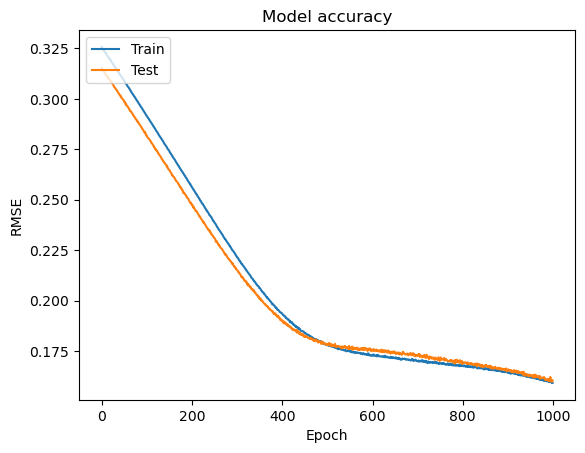

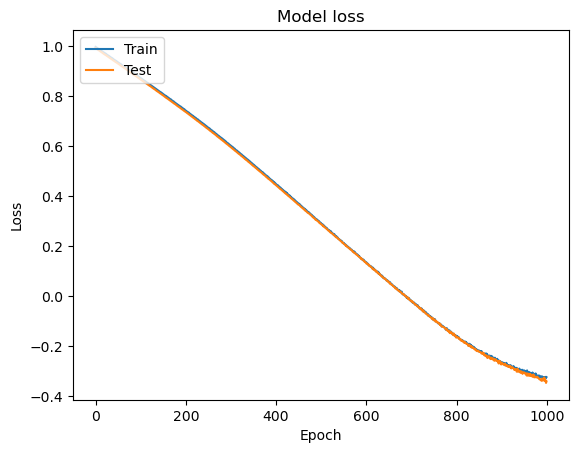

Train log. lik. =  2.159 +/-  0.000
Test  log. lik. =  2.156 +/-  0.000
Train RMSE      =  0.159 +/-  0.000
Test  RMSE      =  0.160 +/-  0.000


In [73]:
net, x_tst, y_tst = train_mc_dropout(data=data, drop_prob=p_drop, num_epochs=nb_epochs, 
                                     ratio_train_data=train_data_ratio, num_units=nb_units, learn_rate=learn_rate, 
                                     weight_decay=wght_decay, num_samples=10, log_every=100)

Test the model using the unique temperature values of the test data and plot the predictions with both epistemic and aleatoric uncertainty. The epistemic uncertainty is obtained by running the BNN (MC dropout) several times.

In [74]:
# Get a tuple of unique values & their first index location from a numpy array
uniqueValues, indicesList = np.unique(x_tst[:,0], return_index=True)
x_tst = x_tst[indicesList]

# Only use the selected unique test data
y_tst = y_tst[indicesList]

x_pred = torch.tensor(x_tst.astype(np.float32)) # convert to torch tensor

samples = []
noises = []
for i in range(100):
    preds = net.network.forward(x_pred).cpu().data.numpy()
    samples.append(denormalize_max_min(preds[:, 0], max_y, min_y))
    noises.append(denormalize_max_min(np.exp(preds[:, 1]), max_y, min_y))

samples = np.array(samples)
noises = np.array(noises)
means = (samples.mean(axis=0)).reshape(-1)

aleatoric = (noises ** 2).mean(axis=0) ** 0.5
epistemic = (samples.var(axis=0) ** 0.5).reshape(-1)
total_unc = (aleatoric ** 2 + epistemic ** 2) ** 0.5

print("Aleatoric uncertainty mean: {0:.4f}, Epistemic uncertainty mean: {1:.4f}, Total uncertainty mean: {2:.4f}"
      .format(aleatoric.mean(), epistemic.mean(), total_unc.mean()))
print("Aleatoric uncertainty std: {0:.4f}, Epistemic uncertainty std: {1:.4f}, Total uncertainty std: {2:.4f}"
      .format(aleatoric.std(), epistemic.std(), total_unc.std()))

Aleatoric uncertainty mean: 0.2866, Epistemic uncertainty mean: 0.0168, Total uncertainty mean: 0.2871
Aleatoric uncertainty std: 0.0147, Epistemic uncertainty std: 0.0033, Total uncertainty std: 0.0146


Plot predictions with predictive mean and variance

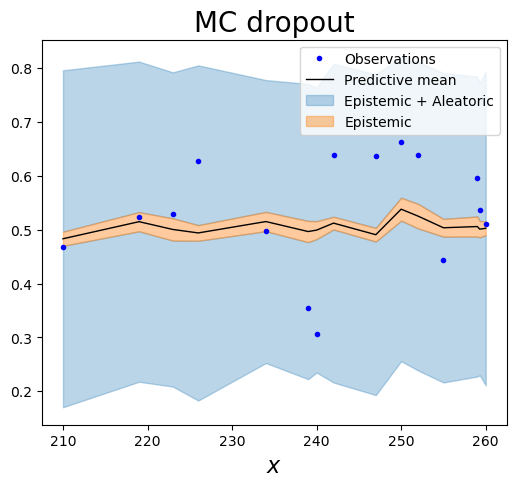

In [75]:
c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# denormalize test data
x_tst = denormalize_max_min(x_tst, max_x, min_x)
y_tst = denormalize_max_min(y_tst, max_y, min_y)


# PLOT FIGURES
plt.figure(figsize=(6, 5))
plt.style.use('default')
plt.plot(x_tst[:,0], y_tst, 'b.', label='Observations');
plt.fill_between(x_tst[:,0], means + epistemic, means + total_unc, color=c[0], alpha=0.3,
                 label='Epistemic + Aleatoric')
plt.fill_between(x_tst[:,0], means - total_unc, means - epistemic, color=c[0], alpha=0.3)
plt.fill_between(x_tst[:,0], means - epistemic, means + epistemic, color=c[1], alpha=0.4,
                 label='Epistemic')
plt.plot(x_tst[:,0], means, color='black', linewidth=1, label='Predictive mean')
plt.xlabel('$x$', fontsize=16)
plt.title('MC dropout', fontsize=20)
plt.legend()
plt.show()